In [1]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchtext.data as data
import torchtext.datasets as datasets

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
class textCNN(nn.Module):
    def __init__(self, vocab, embed_dim, class_num, kernel_num, kernel_sizes):
        super(textCNN, self).__init__()
        
        self.Vocab = vocab 
        self.Dim = embed_dim 
        self.Cla = class_num 
        self.Ci = 1 
        self.Knum = kernel_num 
        self.Ks = kernel_sizes 
        self.dropout=0.2
        
        self.embed = nn.Embedding(self.Vocab, self.Dim) ## 词向量，这里直接随机
        self.convs = nn.ModuleList([nn.Conv2d(self.Ci, self.Knum,(K, self.Dim)) for K in self.Ks]) ## 卷积层
        self.dropout = nn.Dropout(self.dropout) 
        self.fc = nn.Linear(len(self.Ks)*self.Knum, self.Cla) ##全连接层
        
    def forward(self,x):
        x = self.embed(x) #(N,W,D)
        
        x = x.unsqueeze(1) #(N,Ci,W,D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] # len(Ks)*(N,Knum,W)
        #print(x.shape)
        x = [F.max_pool1d(line,line.size(2)).squeeze(2) for line in x]  # len(Ks)*(N,Knum)
        
        x = torch.cat(x,1) #(N,Knum*len(Ks))
        
        x = self.dropout(x)
        logit = self.fc(x)
        return logit
def tokenizer(x):
    res = x.replace(' ','').split(',')
    return res

def save_model(model, save_dir, save_prefix):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    save_prefix = os.path.join(save_dir,save_prefix)
    save_path = '{}.pth'.format(save_prefix)
    torch.save(model.state_dict(),save_path)


In [ ]:
shp_len = 10
shp_num = 100
vocab = shp_num+1+1   # number of known words
embed_dim = 256       #  dimension of embedding representation
class_num = 2         # number of class
kernel_num = 3        
kernel_sizes = [2,3,4,5]
max_epoch = 100
batch_size = 16
learning_rate = 1e-5

save_dir = './experiments/shp2sent/'

torch.cuda.set_device(0)

In [4]:
shp_loc_ts = np.load('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts.npy'.format(shp_len, shp_num),\
                    allow_pickle=True)[()]

shp_seq = shp_loc_ts['shp_seq']
seq_label = shp_loc_ts['seq_label']
print(shp_seq.shape, seq_label.shape)

(1875, 100) (1875,)


In [5]:
X_train,X_test,y_train,y_test = train_test_split(shp_seq, seq_label, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1406, 100) (469, 100) (1406,) (469,)


In [6]:
#train set
ts_num = X_train.shape[0]
dataset = []
for i in range(ts_num):
    text = str([val for val in X_train[i,:] if val != -1])[1:-1]
    dataset.append((text, y_train[i]))
df_train = pd.DataFrame(data=dataset, columns=['text','label'])
print(df_train.shape)

#test set
ts_num = X_test.shape[0]
dataset = []
for i in range(ts_num):
    text = str([val for val in X_test[i,:] if val != -1])[1:-1]
    dataset.append((text, y_test[i]))
df_test = pd.DataFrame(data=dataset, columns=['text','label'])
print(df_test.shape)

(1406, 2)
(469, 2)


In [7]:
df_train.to_csv('train.csv', index=None)
df_test.to_csv('test.csv', index=None)

In [8]:
TEXT = data.Field(sequential=True, tokenize=tokenizer, fix_length=100)
LABEL = data.Field(sequential=False, use_vocab=False)
# train, test = data.TabularDataset.splits(path='./',train='train.csv',
#                                               test='test.csv',
#                                               format='csv',
#                                               skip_header=True,
#                                               fields=[('text', TEXT), ('label', LABEL)])
train = data.TabularDataset(path='./train.csv',
                                      format='csv',
                                      skip_header=True,
                                      fields=[('text', TEXT), ('label', LABEL)])
test = data.TabularDataset(path='./test.csv',
                                      format='csv',
                                      skip_header=True,
                                      fields=[('text', TEXT), ('label', LABEL)])
TEXT.build_vocab(train)
TEXT.build_vocab(test)

In [9]:
train_iter = data.Iterator(train,
                             train=True,
                             batch_size=batch_size,
                             sort_key=None,
                             repeat=False)
test_iter = data.Iterator(test,
                             batch_size=batch_size,
                             sort_key=None,
                             repeat=False)

In [14]:
model = textCNN(vocab=vocab,
                embed_dim=embed_dim,
                class_num=class_num,
                kernel_num=kernel_num,
                kernel_sizes=kernel_sizes)
model = model.to('cuda')
model

textCNN(
  (embed): Embedding(102, 256)
  (convs): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 256), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 256), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 256), stride=(1, 1))
    (3): Conv2d(1, 3, kernel_size=(5, 256), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=12, out_features=2, bias=True)
)

In [15]:
#train
model.train()
train_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print('training...')
for epoch in range(1, max_epoch+1):
    step=0
    losses = []
    for batch in train_iter:
        feature, target = batch.text, batch.label #(W,N) (N)
        feature.t_() #(N,W)
        feature, target = feature.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        logit = model(feature)
        loss = F.cross_entropy(logit, target)
        losses.append(float(loss.cpu()))
        print('\rEpoch {}|step:{} loss:{}'.format(epoch, step, losses[-1]), end='',flush=True)
        loss.backward()
        optimizer.step()
        step+=1
    train_losses.append(np.mean(losses))

training...
Epoch 116|step:79 loss:0.65352571010589645

KeyboardInterrupt: 

In [16]:
#save model
t = time.localtime()
tt = str(t.tm_year)+str(t.tm_mon).zfill(2)+str(t.tm_mday).zfill(2)+str(t.tm_hour).zfill(2)+str(t.tm_min).zfill(2)
save_prefix = 'model_'+tt
save_model(model, save_dir, save_prefix)

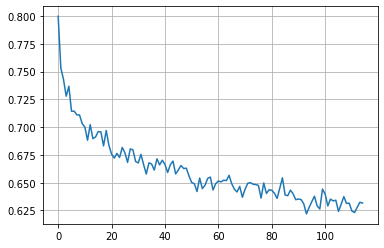

In [17]:
x = list(range(len(train_losses)))
plt.plot(x, train_losses)
plt.grid()

In [18]:
#eval
corrects, avg_loss = 0, 0
y_pred, y_true = [], []
for batch in test_iter:
    feature, target = batch.text, batch.label
    feature.t_()
    feature, target = feature.to('cuda'), target.to('cuda')

    logit = model(feature)
    loss = F.cross_entropy(logit,target)

    avg_loss += loss.item()
    result = torch.max(logit,1)[1]
    corrects += (result.view(target.size()).data == target.data).sum()
    y_pred += result.cpu().numpy().tolist()
    y_true += target.cpu().numpy().tolist()
size = len(test_iter.dataset)
avg_loss /= size 
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print('\nEvaluation - loss: {:.6f} acc: {:.3f} prec: {:.3f} f1: {:.3f} \n'.format(avg_loss,accuracy,precision,f1))


Evaluation - loss: 0.042041 acc: 0.601 prec: 0.486 f1: 0.278 

